In [1]:
import numpy as np
from sklearn.model_selection import ShuffleSplit

from scipy.stats import norm

import keras
from keras import backend as K
from keras.layers import Input, Dense, Lambda, Layer, Add, Multiply
from keras.models import Model, Sequential

import pandas as pd
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [ ]:
from sklearn.feature_extraction import DictVectorizer, FeatureHasher
encoder = FeatureHasher(n_features=10, input_type="string")
encoder = preprocessing.LabelEncoder()

feature_all = {}
y_all = {}

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF
n_components = 20
    
for name, group in tqdm(df_final.groupby('congress')):
    print('Processing congress', name)
    print('congress shape', group.shape)  
    
#     print(encoder.fit_transform(group[['sponsor_id', 'sponsor_party', 'sponsor_state']]).shape)
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=10000,
                                   stop_words='english')

    
    group['sponsor_id'] = encoder.fit_transform(group['sponsor_id'])
    group['sponsor_party'] = encoder.fit_transform(group['sponsor_party'])
    group['sponsor_state'] = encoder.fit_transform(group['sponsor_state'])
#     tf_idf_desc = tfidf_vectorizer.fit_transform(group['vote_desc'].values.astype('U'))
#     print('tf_idf shape', tf_idf_desc.shape)
#     nmf = NMF(n_components=n_components, 
#               random_state=1, beta_loss='kullback-leibler', 
#               solver='mu', max_iter=1000, alpha=.1, l1_ratio=.5).fit_transform(tf_idf_desc)
#     print('nmf shape', nmf.shape)

    X = group[['sponsor_id', 'sponsor_party', 'sponsor_state']]
#     print(X)
#     X = np.hstack((group['sponsor_id'].values.reshape(-1,1), 
#                    group['sponsor_party'].values.reshape(-1,1), 
#                    group['sponsor_state'].values.reshape(-1,1)))
    

#     X = np.hstack((encoder.fit_transform(group['sponsor_id']).reshape(-1,1), 
#                    encoder.fit_transform(group['sponsor_party']).reshape(-1,1), 
#                    encoder.fit_transform(group['sponsor_state']).reshape(-1,1)))
#     X = pd.DataFrame(X)
#     print(X.describe())
#     print(list(encoder.classes_))

    y = group['vote']
    le = preprocessing.LabelEncoder()
    le.fit(y)
#     print(le.classes_)
    y = le.transform(y)
    print(X[:1])
    print(y[:1])

    print('X shape', X.shape)
    print('y shape', y.shape)

    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=42)

    print('X_train', X_train.shape, 'y_train', y_train.shape)
    print('X_test', X_test.shape, 'y_test', y_test.shape)

    
    print((group['vote'].value_counts()))
#     group['vote'].value_counts().plot(kind='bar', alpha=.5)
    group['sponsor_state'].value_counts()[:10].plot(kind='bar', alpha=.5)
             
    break



In [2]:

vote_matrix_all = np.load('data/vote_matrix_all.npy' )
X_seq_all = np.load('data/X_seq_all.npy')
word_index_all = np.load('data/X_word_index_all.npy')
X_train_tf_all = np.load('data/X_train_tf_all.npy')
X_train_counts_all = np.load('data/X_train_counts_all.npy')
X_emb_all = np.load('data/X_emb_all.npy')
legistlator_all = np.load('data/legistlator_all.npy')

print(vote_matrix_all.item()[106].shape)
print(X_seq_all.item()[106].shape)
# print(word_index_all[106].shape)
print(X_train_tf_all.item()[106].shape)
print(X_train_counts_all.item()[106].shape)
print(X_emb_all.item()[106].shape)
# print(legistlator_all.item()[106])



(167, 435)
(167,)
(167, 17563)
(167, 17563)
(167, 300)


In [3]:
#Variational

def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """

    # keras.losses.binary_crossentropy gives the mean
    # over the last axis. we require the sum
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)


class KLDivergenceLayer(Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs


def get_VAE(original_dim):
    decoder = Sequential([
        Dense(intermediate_dim, input_dim=latent_dim, activation='relu'),
        Dense(original_dim, activation='sigmoid')
    ])

    x = Input(shape=(original_dim,))
    h = Dense(intermediate_dim, activation='relu')(x)

    z_mu = Dense(latent_dim)(h)
    z_log_var = Dense(latent_dim)(h)

    z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])
    z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)

    eps = Input(tensor=K.random_normal(stddev=epsilon_std,
                                       shape=(K.shape(x)[0], latent_dim)))
    z_eps = Multiply()([z_sigma, eps])
    z = Add()([z_mu, z_eps])

    x_pred = decoder(z)

    vae = Model(inputs=[x, eps], outputs=x_pred)
    
    loss = nll
    loss = 'mean_squared_error'
    vae.compile(optimizer='adam', loss=loss)

    encoder = Model(x, z_mu)
    return vae, encoder, decoder


In [4]:
from keras.initializers import glorot_uniform  # Or your initializer of choice

def reinitialize(model):
    initial_weights = model.get_weights()
    new_weights = [glorot_uniform()(w.shape).eval() for w in initial_weights]
    model.set_weights(new_weights)
    return model
      
    


In [5]:
X_emb = X_emb_all.item()[106]
vote_matrix = vote_matrix_all.item()[106]
print('X_emb', X_emb.shape)
print('vote_matrix', vote_matrix.shape)

# numpyMatrix = df.as_matrix().astype(float)
# scaled_data = preprocessing.scale(numpyMatrix)

from sklearn.preprocessing import scale, MinMaxScaler, StandardScaler
# X_emb = StandardScaler().fit_transform(X_emb.astype(float))
X_emb = scale(X_emb.astype(float))

X = []
X_meta = []
y = []
i = 0

#     mean = 0.0   # some constant
#     std = 1.0    # some constant (standard deviation)
#     meta = meta + np.random.normal(mean, std, meta.shape)
mu, sigma = 0, 0.1 # mean and standard deviation
noise_factor = 0.5

X_train = []
######
# Create Meta for each legistlator
for idx, legistlator in enumerate(vote_matrix.T):
#     print('np.vstack(legistlator)', np.vstack(legistlator).shape)
#     print('legistlator.shape', legistlator.shape)
#     legistlator = legistlator + np.random.normal(mu, sigma, legistlator.shape)

    meta = np.multiply(X_emb, np.vstack(legistlator)) # Eelementwise multiplication, introducing noise


    meta = meta + noise_factor * np.random.normal(mu, sigma, meta.shape)

#     print('meta.shape', meta.shape)
    
    X_meta.append(meta)
    X_train.append(X_emb)

#     break
######
X_meta = np.array(X_meta)
X_train = np.array(X_train)
print('X_meta', X_meta.shape)
print('X_train', X_train.shape)


# Reshape to flatten the dimentions
# X_train = X_train.reshape(X_train.shape[0], -1)
# X_meta = X_meta.reshape(X_meta.shape[0], -1)
# X_train = X_train.reshape(-1, X_train.shape[1], X_train.shape[2], 1)
# X_meta = X_meta.reshape(-1, X_meta.shape[1], X_meta.shape[2], 1)

X_train =  np.clip(X_train, -1., 1.)
X_meta = np.clip(X_meta, -1., 1.)
print('X_train new shape', X_train.shape)
print('X_meta new shape', X_meta.shape)

print(X_train[0].shape)
print(X_meta[0])



X_emb (167, 300)
vote_matrix (167, 435)
X_meta (435, 167, 300)
X_train (435, 167, 300)
X_train new shape (435, 167, 300)
X_meta new shape (435, 167, 300)
(167, 300)
[[ 0.4825354  -0.87425696  0.32159408 ... -0.26271629 -0.64067532
  -0.27780402]
 [ 0.46867788 -0.58312602  0.48291334 ...  0.00436518 -0.41854216
   0.0656492 ]
 [-0.01082105  0.19470767  0.06788067 ... -0.03374893  0.05979728
   0.08913655]
 ...
 [-0.26898635  0.36104397  1.         ...  1.          1.
   0.2320706 ]
 [ 0.01469368  0.06445051  0.06595016 ... -0.01713964  0.09726893
  -0.03515295]
 [ 0.04494724  0.03371028 -0.04445521 ...  0.01391445 -0.08335289
   0.04289823]]


In [6]:
def deep_autoencoder(X_train):
    input_img = Input(shape=(X_train.shape[1], X_train.shape[2]))
    encoded = Dense(128, activation='relu', kernel_initializer='glorot_uniform')(input_img)
    encoded = Dense(64, activation='relu')(encoded)
    encoded = Dense(32, activation='relu',  name='encoded')(encoded)

    decoded = Dense(64, activation='relu')(encoded)
    decoded = Dense(128, activation='relu')(decoded)
    decoded = Dense(X_train.shape[2], activation='sigmoid')(decoded)
    autoencoder = Model(input_img, decoded)
#     loss = 'mean_squared_error'
    loss='binary_crossentropy'
    autoencoder.compile(optimizer='adam', loss=loss)
    return autoencoder

def denoiser_autoencoder(X_train):
#     input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format
    input_img = Input(shape = (X_train.shape[1], X_train.shape[2], 1 ))
    x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='glorot_uniform')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # at this point the representation is (7, 7, 32)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    return autoencoder

    
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D


def conv_autoencoder(X_train):
    
    input_img = Input(shape = (1, X_train.shape[1], X_train.shape[2] ))
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', name='encoded')(pool2) #7 x 7 x 128 (small and thick)

    #decoder
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 128
    up1 = UpSampling2D((2,2))(conv4) # 14 x 14 x 128
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 64
    up2 = UpSampling2D((2,2))(conv5) # 28 x 28 x 64
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='decoded')(up2) # 28 x 28 x 1
    
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(loss='mean_squared_error', optimizer = 'RMSprop')
    return autoencoder

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 167, 300)          0         
_________________________________________________________________
dense_6 (Dense)              (None, 167, 128)          38528     
_________________________________________________________________
dense_7 (Dense)              (None, 167, 64)           8256      
_________________________________________________________________
encoded (Dense)              (None, 167, 32)           2080      
_________________________________________________________________
dense_8 (Dense)              (None, 167, 64)           2112      
_________________________________________________________________
dense_9 (Dense)              (None, 167, 128)          8320      
_________________________________________________________________
dense_10 (Dense)             (None, 167, 300)          38700     
Total para

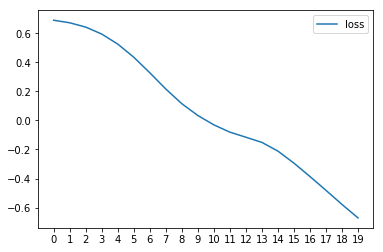

In [8]:
###################
# original_dim = 
intermediate_dim = 256
latent_dim = 128
batch_size = 256
epochs = 20
epsilon_std = 1.0
###################

# autoencoder, encoder, decoder = get_VAE(original_dim)
autoencoder = deep_autoencoder(X_train)
# autoencoder = denoiser_autoencoder(X_train)
# autoencoder = conv_autoencoder(X_train)
print(autoencoder.summary())

rs = ShuffleSplit(n_splits=3, test_size=.25, random_state=0)
rs.get_n_splits(X_train)

print(rs)

def plot_history(history):
    print(history.history)
    df = pd.DataFrame(history.history)
#     print(df.tail())
    df.plot(xticks=range(epochs))
#     print(history.history.keys())

    
for train_index, test_index in rs.split(X_train):
#     print("TRAIN:", train_index, "TEST:", test_index)
    X_emb_train, X_emb_test = X_train[train_index], X_train[test_index]
    X_meta_train, X_meta_test = X_meta[train_index], X_meta[test_index]
    
    print(X_emb_train.shape, X_emb_test.shape)
    print(X_meta_train.shape, X_meta_test.shape)
#     break
    
    history = autoencoder.fit(X_emb_train,
        X_meta_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size)
    plot_history(history)
    
    
    ###
    names = [weight.name for layer in autoencoder.layers for weight in layer.weights]
    weights = autoencoder.get_weights()

    for name, weight in zip(names, weights):
        print(name, weight.shape)
        
#     encoded_weight = 
#     print(model_weights['encoded'].shape, model_weights['encoded'])

    ###
    
    
    break

In [ ]:
from sklearn.model_selection import train_test_split

# split into a training and testing set
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)